<a href="https://colab.research.google.com/github/ddodds42/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/DAVID_DODDS_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
explore = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

explore.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
target = 'status_group'

train, val = train_test_split(explore, train_size=0.8, test_size=0.2,
                              stratify=explore[target], random_state=42)
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [6]:
def munge(df):
  df = df.copy()
  df['latitude'] = df['latitude'].replace(-2e-08,0)
  cols_w_zeros = ['longitude', 'latitude', 'construction_year', 'gps_height',
                  'population']
  for col in cols_w_zeros:
    df[col] = df[col].replace(0,np.nan)
    df[col+'_MISSING'] = df[col].isnull() 
  df = df.drop(columns=['quantity_group','payment_type','recorded_by', 'id'])
  df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True)
  df['year_recorded'] = df['date_recorded'].dt.year
  df['month_recorded'] = df['date_recorded'].dt.month
  df['day_recorded'] = df['date_recorded'].dt.day
  df = df.drop(columns='date_recorded')
  df['years'] = df['year_recorded'] - df['construction_year']
  df['years_MISSING'] = df['years'].isnull()
  return df

In [7]:
train = munge(train)
val = munge(val)
test = munge(test)

train.shape, val.shape, test.shape

((47520, 46), (11880, 46), (14358, 45))

In [8]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((47520, 45), (47520,), (11880, 45), (11880,))

In [9]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [10]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

k=10

scores = cross_val_score(pipeline, X_train, y_train, cv=k)
print(f'Accuracy for {k} folds = ', scores)
print(scores.mean())

Accuracy for 10 folds =  [0.8013468  0.80324074 0.80513468 0.80492424 0.81123737 0.80597643
 0.80702862 0.80787037 0.80576599 0.80850168]
0.8061026936026936
Wall time: 2min 9s


In [11]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy = ', accuracy_score(y_val, y_pred))

Validation Accuracy =  0.8135521885521886


In [12]:
import sklearn
sklearn.__version__

'0.22.1'

In [13]:
from sklearn.metrics import plot_confusion_matrix

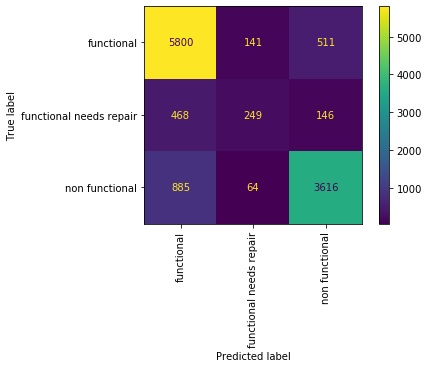

In [16]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='d', xticks_rotation='vertical')

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

In [84]:
pipeline0 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_jobs=-1,
                           max_depth=18, min_samples_leaf=1,
                           n_estimators=464, max_features=0.1337)
)

param_dist = {
#     'simpleimputer__strategy': ['mean', 'median'],
#     'randomforestclassifier__max_depth': range(17,22),
#     'randomforestclassifier__min_samples_leaf': range(3,21),
#     'randomforestclassifier__class_weight': [None, 'balanced', 'balanced_subsample'],
#     'randomforestclassifier__n_estimators': randint(450,472),
#     'randomforestclassifier__max_features': uniform(0, 0.20),
}

search = RandomizedSearchCV(
    pipeline0, 
    param_distributions=param_dist, 
    n_iter=5, 
    cv=5, 
    verbose=10,
    scoring='accuracy', 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

C:\Users\David.000\Anaconda3\envs\unit2\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


In [85]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', search.best_score_)

Best hyperparameters {}
Cross-validation Accuracy 0.8080387205387206


In [87]:
y_pred = search.predict(test)
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [88]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission_tuned_DODDS.csv', index=False)

## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [x] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

# Classification Metrics

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [x] Plot a confusion matrix for your Tanzania Waterpumps model.
- [x] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [x] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [x] Commit your notebook to your fork of the GitHub repo.
- [x] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.